### Table of contents
[Imports](#funcs)

[Parameters, filenames and directories](#params)

[Reading datasets](#readCatalogs)

[Training SOMs](#SOM_Train)

[Calculating SOM_info for dataset](#SOM_info)

[Building and saving maps](#SOM_maps)

[Adding outlier coefficients for specZ, ML and SED photoZ and quantErr](#outlCoeff)

[Saving datasets with SOM_info](#save)

In [9]:
### import libraries ###
import time
import numpy as np
import minisom
import os
import pandas as pd
from func_SOM_read_write import createSOM, writeSOM, loadSOM
from func_add_SOM_info import addBMUWeights, addQuantErr, addCellAddress, calcOutlCoeff, addOccupation
from func_maps import buildMaps, writeMaps,readMaps
from func_dataset_preprocessing import residCol, scaleMags, mergeCatalogs

### Parameters, filenames and directories
<a id='params'>#params<a>

In [2]:
### Parameters of SOM experiment ###
nameOfExperiment='ex019'
width=25
height=28
widthBig=64
heightBig=67
num_features=10
epochs=6000
sigma=5
learning_rate=0.5
neighborhood_function='bubble'

In [3]:
### Files and directories ###
dirCatalogs=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\catalogs\forPaper\v05\NoQfClean'
dirSOM=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\SOM\forArticle'

nameTrainNoQf=r'05_COSMOS_SpectrZ_Zlim_1p2.csv'

In [4]:
### Create experiment folder ###
if os.path.isdir(dirSOM):
    os.mkdir(os.path.join(dirSOM,nameOfExperiment))
else:
    os.makedirs(os.path.join(dirSOM,nameOfExperiment)) 
timeName=time.strftime("%y%m%d_%H%M%S_", time.gmtime())

In [6]:
### Write parameters on log file ###
logName=timeName+'_log.txt'
with open(os.path.join(dirSOM,nameOfExperiment,logName), 'a+') as f:
    f.write('Catalog='+nameTrainNoQf+'\n')
    f.write('width='+str(width)+'\n')
    f.write('height='+str(height)+'\n')
    f.write('widthBig='+str(widthBig)+'\n')
    f.write('heightBig='+str(heightBig)+'\n')
    f.write('num_features='+str(num_features)+'\n')
    f.write('epochs='+str(epochs)+'\n')
    f.write('sigma='+str(sigma)+'\n')
    f.write('learning rate='+str(learning_rate)+'\n')
    f.write('neighborhood_function='+str(neighborhood_function)+'\n')

In [7]:
### Column names for training and filtering ###
mags=['Ksmagap3','Ymagap3','Hmagap3','Jmagap3','Bmagap3','Vmagap3','ipmagap3','rmagap3','umagap3','zppmagap3']
magsScaled=['sc_'+s for s in mags]
idCol='Seq'
specZ='z_spec'
quantErr='quantErr'

### Reading datasets
<a id='readCatalogs'>#readCatalogs<a>

In [8]:
### Read catalogs ###
dataTrain=pd.read_csv(os.path.join(dirCatalogs,nameTrainNoQf))

In [10]:
dataTrain=scaleMags(dataTrain,mags,magsScaled)

### Training SOMs
<a id='SOM_Train'>#SOM_Train<a>

In [13]:
data=np.array(dataTrain[magsScaled])
somTrain=createSOM(data, epochs, height, width, num_features, sigma, learning_rate, 
                neighborhood_function, saveWeightsName=os.path.join(dirSOM,nameOfExperiment,'somTrainWeights.txt'))

In [14]:
### Checking that after writing/loading cycle SOM weights were the same ###
soms=[somTrain]
somNames=['somTrainWeights.txt']
for som,somName in zip(soms,somNames):
    somCheck=loadSOM(weightsFile=os.path.join(dirSOM,nameOfExperiment,somName),
                 sigma=sigma,learning_rate=learning_rate,neighborhood_function=neighborhood_function,random_seed=10)
    print(abs((som.get_weights()-somCheck.get_weights())).max())

4.998779168374767e-13


### Calculating SOM_info for dataset
<a id='SOM_info'>#SOM_info<a>

In [15]:
### Adding weights of BMU for each galaxy in a dataset ###
dataTrain=addBMUWeights(somTrain,dataTrain,magsScaled)

In [16]:
### Adding quantization errors for each galaxy ###
dataTrain=addQuantErr(dataTrain,magsScaled,colWeights=None)

In [17]:
### Adding cellIDs for each galaxy ###
soms=[somTrain]
prefixes=['_TrainSOM']
for som,prefix in zip(soms,prefixes):
    dataTrain=addCellAddress(som, dataTrain, magsScaled, idCol,cellIDPrefix=prefix)

### Building and saving maps
<a id='SOM_maps'>#SOM_maps<a>

In [20]:
mapsAll={}
    
mapCols=[specZ,'quantErr']

cellID='cellID_TrainSOM'
som=somTrain
mapsAll['mapsTrainOnTrain']=buildMaps(som,dataTrain,mapCols,idCol,cellID=cellID)

In [21]:
### Saving maps ###
dirMaps='maps'
os.mkdir(os.path.join(dirSOM,nameOfExperiment,dirMaps))
for key,val in mapsAll.items():
    writeMaps(val,prefixName=os.path.join(dirSOM,nameOfExperiment,dirMaps,key))

### Adding outlier coefficients for specZ, ML and SED photoZ and quantErr
<a id='outlCoeff'>#outlCoeff<a>

In [22]:
filterCols=[specZ,quantErr]
maps=mapsAll['mapsTrainOnTrain']
cellID='cellID_TrainSOM'
for col in filterCols:
    dataTrain=calcOutlCoeff(dataTrain,maps['stdMaps'][col],maps['meanMaps'][col],col,cellID,prefix='')

### Adding occupation info
<a id='addOccupation'>#addOccupation<a>

In [25]:
cellID='cellID_TrainSOM'
activMap=mapsAll['mapsTrainOnTrain']['activMap']
datasets=[dataTrain]
for dataset in datasets:
    dataset=addOccupation(dataset,cellID,activMap)

### Saving datasets with SOM_info
<a id='save'>#save<a>

In [30]:
### Saving datasets with added data ###
dirDatasets='datasets'
os.mkdir(os.path.join(dirSOM,nameOfExperiment,dirDatasets))
datasets=[dataTrain]
names=[nameTrainNoQf]
for dataset,name in zip(datasets,names):
    dataset.to_csv(os.path.join(dirSOM,nameOfExperiment,dirDatasets,name.replace('.csv','_SOMinfo.csv')),index=False)

### Does specZ_outlCoeff correlate with Q_f?

In [32]:
import matplotlib.pyplot as plt

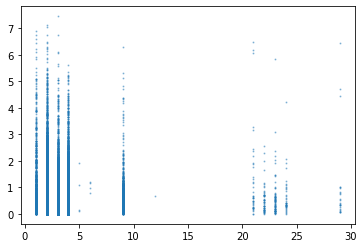

In [38]:
plt.scatter(dataset['Q_f'],dataset['z_spec_outlCoeff'].abs(),s=1,alpha=0.4)

In [41]:
d=dataset[dataset['z_spec_outlCoeff'].abs()<=1]
d.to_csv(os.path.join(dirSOM,nameOfExperiment,dirDatasets,name.replace('.csv','_specZOutlCoeff_filter.csv')),index=False)

In [42]:
d=dataset.sample(n=len(dataset[dataset['z_spec_outlCoeff'].abs()<=1]))
d.to_csv(os.path.join(dirSOM,nameOfExperiment,dirDatasets,name.replace('.csv','_randSample.csv')),index=False)